In [1]:
# import standard data science packages
import pandas as pd
import numpy as np

# import packages related to web scraping
from bs4 import BeautifulSoup, NavigableString, Tag
import requests
import wget

# import package to handle zipfiles
from zipfile import ZipFile

# import json related packages
from pandas.io.json import json_normalize
import json

# import clustering related packages
from sklearn.cluster import KMeans
from sklearn import metrics

# import hierarchichal clustering and dendrogram related packages
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# import sleep to avoid too many requests in a short time-span
from time import sleep

# import visualisation related packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# import geolocation related packages
from geopy.geocoders import Nominatim

## Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a id="introduction"></a>

In this project we will compare 6 capital cities to find out which capital is most similar given the venues in its neighborhoods. This project would be targeted specifically at travel agencies who wish to recommend the best capital to customers who expressed wanting to visit a place similar to New York.

To avoid western bias, 2 capital cities for 3 continents will be compared. As venues can be categorised at a highly detailed level which can contain a cultural bias (e.g. Japanese and Korean restaurants), venue categories at a semi-high level will be used.

## Data <a id="data"></a>

Based on the criteria defined above. Three types of data will be needed.

- Boroughs and neighborhoods for 6 selected capitals (New York, Toronto, Tokyo, Seoul, Berlin and London) 
- Coordinates for neighborhoods
- Venues in a set radius for each of the coordinates

#### Boroughs and neighborhoods
This data will be gathered from public datasets if available, otherwise these will be scraped from wikipedia

#### Coordinates
This data will be gathered from public datasets if available, otherwise these will be gathered with the geopy.geocoders package using neighborhood names. Missing coordinates will be appended manually from google maps if the api fails.

#### Venues
This data will be gathered by using the foursquare API

### Geolocation Data

Let's define a function to get coordinates from an address

In [2]:
def getLatitudeLongitude(address,user_agent='tokyo_explorer'):
    print(address)
    geolocator = Nominatim(user_agent=user_agent)
    for i in range(10):
        try:
            location = geolocator.geocode(address)
            break
        except:
            sleep(0.1)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = ''
        longitude = ''
    return(latitude,longitude)

Since a lot of maps will be created for this study, let's create a function to create maps with folium

In [3]:
def mapCity(data,center_latitude,center_longitude,zoom_start):
    # create map of the city using latitude and longitude values
    map_data = folium.Map(location=[center_latitude, center_longitude], zoom_start=zoom_start)

    # add markers to map
    for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_data) 

    return map_data

#### Toronto

Let's get neighborhood data for Toronto by web scraping the neighborhood names from the Canadian postal codes wikipedia page and merging that with a dataset of locations per postal code.

In [4]:
# get the wiki page
wiki = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(wiki,'lxml')
# find the table containing postal code information
table = soup.find('table',{'class':'wikitable'})
rows = []

# iterate every row in the table
for row in table.findAll('tr'):
#     get non header information from the row
    cells = row.findAll('td')
#     if cells is not empy (if row is not the header row)
    if len(cells) > 0:
#         assign borough text to a variable
        borough = cells[1].find(text=True).rstrip()
# only process cells with an assigned borough
        if 'Not assigned' not in borough:
#         assign postal code and neighborhood to variables
            pc = cells[0].find(text=True).rstrip()
            nb = cells[2].find(text=True).rstrip()
#             if neighborhood is not assigned, set the neighborhood equal to the borough
            if 'Not assigned' in nb:
                nb = borough
#             if borough contains multiple boroughs separated by ' / ',
#             replace ' / ' with a ', ' to conform with the second condition
            elif '/' in nb:
                nb = nb.replace(' / ',', ')
#             add postal code, borough and neigborhood to list
            rows.append((pc,borough,nb))
    
# create the dataframe based on the list of tuples with columnnames as specified in the assignment
toronto = pd.DataFrame(rows,columns=['PostalCode','Borough','Neighborhood'])

# get geopsatial data
url = 'http://cocl.us/Geospatial_data'
output = 'toronto_geospatial.csv'
filename = wget.download(url,output)

geo_df = pd.read_csv(filename)
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
# merge datasets
toronto = pd.merge(toronto,geo_df,on='PostalCode',how='left')
toronto.insert(0,'City','Toronto')
toronto.head()

100% [.........................................................................] 2891 / 2891

City PostalCode           Borough  \
0  Toronto        M3A        North York   
1  Toronto        M4A        North York   
2  Toronto        M5A  Downtown Toronto   
3  Toronto        M6A        North York   
4  Toronto        M7A  Downtown Toronto   

                                  Neighborhood   Latitude  Longitude  
0                                    Parkwoods  43.753259 -79.329656  
1                             Victoria Village  43.725882 -79.315572  
2                    Regent Park, Harbourfront  43.654260 -79.360636  
3             Lawrence Manor, Lawrence Heights  43.718518 -79.464763  
4  Queen's Park, Ontario Provincial Government  43.662301 -79.389494

Looks good so far, let's have  a quick sanity check by mapping these coordinates with folium.
First we need some coordinates for Toronto itself to center our map

In [5]:
toronto_latitude,toronto_longitude = getLatitudeLongitude('Toronto,Canada')

Toronto,Canada


Let's map Toronto

In [6]:
mapCity(toronto,toronto_latitude,toronto_longitude,9)

Everything seems fine, so we can drop the 'PostalCode' column since it won't be needed in the next steps

In [7]:
toronto.drop('PostalCode',1,inplace=True)

#### New York

Let's get neighborhood data for New York by downloading a dataset

In [8]:
# fetch the new york datasete json file
url = 'https://cocl.us/new_york_dataset'
out = 'newyork_data.json'
filename = wget.download(url,out)
print('Data downloaded!')

with open(filename) as json_data:
    newyork_data = json.load(json_data)
    
newyork_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork = pd.DataFrame(columns=column_names)

for data in newyork_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork = newyork.append(
        {'Borough': borough,
        'Neighborhood': neighborhood_name,
        'Latitude': neighborhood_lat,
        'Longitude': neighborhood_lon}, ignore_index=True)
    
newyork.insert(0,'City','New York')
newyork.head()

100% [.....................................................................] 115774 / 115774Data downloaded!


City Borough Neighborhood   Latitude  Longitude
0  New York   Bronx    Wakefield  40.894705 -73.847201
1  New York   Bronx   Co-op City  40.874294 -73.829939
2  New York   Bronx  Eastchester  40.887556 -73.827806
3  New York   Bronx    Fieldston  40.895437 -73.905643
4  New York   Bronx    Riverdale  40.890834 -73.912585

In [9]:
newyork_latitude,newyork_longitude = getLatitudeLongitude('New York, USA')

New York, USA


In [10]:
mapCity(newyork,newyork_latitude,newyork_longitude,9)

Everything seems fine, so we can move on to the next city

#### Tokyo

Let's get neighborhood data of Tokyo by scraping it from wikipedia

In [11]:
# get the Tokyo special wards wiki page
jp_pc = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text
soup = BeautifulSoup(jp_pc,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})

rows = []

# iterate every row in the table
for row in table.findAll('tr'):
#     get non header information from the row
    cells = row.findAll('td')
#     if cells is not empy (if row is not the header row)
    if len(cells) == 8:
        ward = cells[2].find(text=True).rstrip()
        districts = cells[7].findAll(text=True)
        for d in districts:
            d = d.replace(',','').strip()
            if d != '':
                if ' ' in d:
                    ds = d.split()
                    for di in ds:
                        rows.append((ward,di))
                    
                else:
                    rows.append((ward,d))
                    
tokyo = pd.DataFrame(rows,columns=['Borough','Neighborhood'])
tokyo.insert(0,'City','Tokyo')

Let's apply the function we defined previously to get coordinates for the neighborhoods in Tokyo and count the neighborhoods that weren't assigned coordinates

In [12]:
tokyo['coordinates'] = tokyo['Neighborhood'].apply(lambda x: getLatitudeLongitude(x+', Tokyo'))
print(len(tokyo[tokyo['coordinates'] == ('','')]))

Nagatachō, Tokyo
Kasumigaseki, Tokyo
Ōtemachi, Tokyo
Marunouchi, Tokyo
Akihabara, Tokyo
Yūrakuchō, Tokyo
Iidabashi, Tokyo
Kanda, Tokyo
Nihonbashi, Tokyo
Kayabachō, Tokyo
Ginza, Tokyo
Tsukiji, Tokyo
Hatchōbori, Tokyo
Shinkawa, Tokyo
Tsukishima, Tokyo
Kachidoki, Tokyo
Tsukuda, Tokyo
Odaiba, Tokyo
Shinbashi, Tokyo
Hamamatsuchō, Tokyo
Mita, Tokyo
Roppongi, Tokyo
Toranomon, Tokyo
Aoyama, Tokyo
Azabu, Tokyo
Shinjuku, Tokyo
Takadanobaba, Tokyo
Ōkubo, Tokyo
Kagurazaka, Tokyo
Ichigaya, Tokyo
Yotsuya, Tokyo
Hongō, Tokyo
Yayoi, Tokyo
Hakusan, Tokyo
Ueno, Tokyo
Asakusa, Tokyo
Kinshichō, Tokyo
Morishita, Tokyo
Ryōgoku, Tokyo
Kiba, Tokyo
Ariake, Tokyo
Kameido, Tokyo
Tōyōchō, Tokyo
Monzennakachō, Tokyo
Fukagawa, Tokyo
Kiyosumi, Tokyo
Shirakawa, Tokyo
Etchūjima, Tokyo
Sunamachi, Tokyo
Aomi, Tokyo
Shinagawa, Tokyo
Gotanda, Tokyo
Ōsaki, Tokyo
Hatanodai, Tokyo
Ōimachi, Tokyo
Tennōzu, Tokyo
Meguro, Tokyo
Nakameguro, Tokyo
Jiyugaoka, Tokyo
Komaba, Tokyo
Aobadai, Tokyo
Ōmori, Tokyo
Kamata, Tokyo
Haneda, Tok

All the neighborhoods have been assigned coordinates so let's split the coordinates column into a latitude and longitude column

In [13]:
tokyo[['Latitude','Longitude']] = pd.DataFrame(tokyo['coordinates'].tolist(), index=tokyo.index)

Let's have a look at the tokyo dataset

In [14]:
tokyo.head()

City  Borough  Neighborhood                coordinates   Latitude  \
0  Tokyo  Chiyoda     Nagatachō   (35.675618, 139.7434685)  35.675618   
1  Tokyo  Chiyoda  Kasumigaseki  (35.6740542, 139.7509719)  35.674054   
2  Tokyo  Chiyoda      Ōtemachi   (35.686757, 139.7636157)  35.686757   
3  Tokyo  Chiyoda    Marunouchi  (35.6777691, 139.7646365)  35.677769   
4  Tokyo  Chiyoda     Akihabara  (35.6997364, 139.7712503)  35.699736   

    Longitude  
0  139.743469  
1  139.750972  
2  139.763616  
3  139.764636  
4  139.771250

Looks good so far, let's have  a quick sanity check by mapping these coordinates with folium.
First we need some coordinates for Tokyo itself to center our map

In [15]:
tokyo_latitude,tokyo_longitude = getLatitudeLongitude('Tokyo,Japan')

Tokyo,Japan


Let's map Tokyo

In [16]:
mapCity(tokyo,tokyo_latitude,tokyo_longitude,6)

It seems three points were assigned wrong coordinates and lay too far in the west.
Let's single out these three point

In [17]:
tokyo_miss = tokyo.sort_values(by='Longitude').head(3).index.values
tokyo.loc[tokyo_miss]

City   Borough Neighborhood                coordinates   Latitude  \
60  Tokyo    Meguro      Aobadai    (33.857724, 132.735192)  33.857724   
23  Tokyo    Minato       Aoyama   (35.728761, 139.2910113)  35.728761   
69  Tokyo  Setagaya     Tamagawa  (35.6855417, 139.4067251)  35.685542   

     Longitude  
60  132.735192  
23  139.291011  
69  139.406725

Since the first function returned wrong coordinates for these three point, let's define a slight variation of that function

In [18]:
def getLatitudeLongitude2(row,user_agent='tokyo_explorer'):
#     define address as the combination of neighborhood, borough and city
    address = f"{row['Neighborhood']} {row['Borough']}, {row['City']}"
    print(address)
    geolocator = Nominatim(user_agent=user_agent)
#     try 10 times
    for i in range(10):
        try:
            location = geolocator.geocode(address)
            break
        except:
#             sleep to avoid too many api calls in a short amount of time
            sleep(0.1)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = ''
        longitude = ''
    return(latitude,longitude)

Let's get the right coordinates for these three points

In [19]:
tokyo.loc[tokyo_miss,'coordinates'] = tokyo.loc[tokyo_miss].apply(lambda x: getLatitudeLongitude2(x),axis=1)
tokyo[['Latitude','Longitude']] = pd.DataFrame(tokyo['coordinates'].tolist(), index=tokyo.index)
tokyo.loc[tokyo_miss]

Aobadai Meguro, Tokyo
Aoyama Minato, Tokyo
Tamagawa Setagaya, Tokyo


City   Borough Neighborhood                       coordinates   Latitude  \
60  Tokyo    Meguro      Aobadai  (35.6526602, 139.69044642155853)  35.652660   
23  Tokyo    Minato       Aoyama         (35.6710729, 139.7208385)  35.671073   
69  Tokyo  Setagaya     Tamagawa         (35.6051513, 139.6388025)  35.605151   

     Longitude  
60  139.690446  
23  139.720839  
69  139.638802

Let's recheck the map

In [20]:
mapCity(tokyo,tokyo_latitude,tokyo_longitude,6)

Everything seems fine this time, so we can drop the 'coordinates' column since it won't be needed in the next steps

In [21]:
tokyo.drop('coordinates',1,inplace=True)

#### Seoul

Let's get neighborhood data for Seoul by web scraping it from wikipedia

In [22]:
# get the districts of Seould wikipedia page
sl = requests.get('https://en.wikipedia.org/wiki/List_of_districts_of_Seoul').text
soup = BeautifulSoup(sl,'lxml')
table = soup.findAll('table',{'class':'wikitable'})[1]

rows = []

# iterate every row in the table
for row in table.findAll('tr'):
#     get non header information from the row
    cells = row.findAll('td')
#     if cells is not empy (if row is not the header row)
    if len(cells) == 6:
        borough = cells[0].find(text=True)
        neighborhoods = cells[1].findAll('li')
        
        if len(neighborhoods) > 0:
            for n in neighborhoods:
                rows.append((borough,n.find(text=True)))
                
        else:
            rows.append((borough,borough))
            
seoul = pd.DataFrame(rows,columns=['Borough','Neighborhood'])
seoul.insert(0,'City','Seoul')
seoul.head()

City        Borough        Neighborhood
0  Seoul      Dobong-gu         Dobong-dong
1  Seoul      Dobong-gu        Banghak-dong
2  Seoul      Dobong-gu       Ssangmun-dong
3  Seoul      Dobong-gu          Chang-dong
4  Seoul  Dongdaemun-gu  Cheongnyangni-dong

Let's apply the function we defined previously to get coordinates for the neighborhoods in Seoul and count the neighborhoods that weren't assigned coordinates

In [23]:
seoul['coordinates'] = seoul['Neighborhood'].apply(lambda x: getLatitudeLongitude(x+', Seoul','seoul_explorer'))
print(len(seoul[seoul['coordinates'] == ('','')]))

Dobong-dong, Seoul
Banghak-dong, Seoul
Ssangmun-dong, Seoul
Chang-dong, Seoul
Cheongnyangni-dong, Seoul
Dapsimni-dong, Seoul
Hoegi-dong, Seoul
Hwigyeong-dong, Seoul
Imun-dong, Seoul
Jegi-dong, Seoul
Jangan-dong, Seoul
Jeonnong-dong, Seoul
Sinseol-dong, Seoul
Yongdu-dong, Seoul
Bon-dong, Seoul
Daebang-dong, Seoul
Dongjak-dong, Seoul
Heukseok-dong, Seoul
Noryangjin-dong, Seoul
Sadang-dong, Seoul
Sangdo-dong, Seoul
Sindaebang-dong, Seoul
Bulgwang-dong, Seoul
Daejo-dong, Seoul
Eungam-dong, Seoul
Galhyeon-dong, Seoul
Gusan-dong, Seoul
Jeungsan-dong, Seoul
Jingwan-dong, Seoul
Nokbeon-dong, Seoul
Sinsa-dong, Seoul
Susaek-dong, Seoul
Yeokchon-dong, Seoul
Mia-dong, Seoul
Beon-dong, Seoul
Suyu-dong, Seoul
Ui-dong, Seoul
Gangil-dong, Seoul
Godeok-dong, Seoul
Gil-dong, Seoul
Dunchon-dong, Seoul
Myeongil-dong, Seoul
Sangil-dong, Seoul
Seongnae-dong, Seoul
Amsa-dong, Seoul
Cheonho-dong, Seoul
Apgujeong-dong, Seoul
Cheongdam-dong, Seoul
Daechi-dong, Seoul
Dogok-dong, Seoul
Gaepo-dong, Seoul
Irwon-don

7 neighborhoods weren't assigned coordinates so let's print those and figure out our next step

In [24]:
seoul[seoul['coordinates'] == ('','')]

City       Borough            Neighborhood coordinates
108  Seoul     Jongno-gu  Jongno-1.2.3.4 ga-dong        (, )
109  Seoul     Jongno-gu      Jongno-5.6 ga-dong        (, )
202  Seoul  Seongdong-gu      Seongsu 1ga 1 dong        (, )
203  Seoul  Seongdong-gu      Seongsu 1ga 2 dong        (, )
204  Seoul  Seongdong-gu      Seongsu 2ga 1-dong        (, )
205  Seoul  Seongdong-gu      Seongsu 2ga 3-dong        (, )
242  Seoul    Yongsan-gu           Namyoung-dong        (, )

6 of the neighborhoods contains numbers and the last one contains a spelling error. Let's group the numbered neighborhoods into a bigger neighborhood and fix the spelling mistake

In [25]:
replace_dict = {
    'Neighborhood':{
        'Jongno-1.2.3.4 ga-dong':'Jongno-dong',
        'Jongno-5.6 ga-dong':'Jongno-dong',
        'Namyoung-dong':'Namyeong-dong',
        'Seongsu 1ga 1 dong':'Seongsu-dong',
        'Seongsu 1ga 2 dong':'Seongsu-dong',
        'Seongsu 2ga 1-dong':'Seongsu-dong',
        'Seongsu 2ga 3-dong':'Seongsu-dong'
    }
}
seoul.replace(replace_dict,inplace=True)
seoul.drop_duplicates(subset=['Borough','Neighborhood'],inplace=True)

Let's retry assigning coordinates to these neighborhoods

In [26]:
seoul.loc[seoul['coordinates'] == ('',''),'coordinates']= seoul.loc[seoul['coordinates'] == ('',''),'Neighborhood'].apply(lambda x: getLatitudeLongitude(x,'seoul_explorer'))
print(len(seoul[seoul['coordinates'] == ('','')]))

Jongno-dong
Seongsu-dong
Namyeong-dong
0


All the neighborhoods have been assigned coordinates so let's split the coordinates column into a latitude and longitude column

In [27]:
seoul[['Latitude','Longitude']] = pd.DataFrame(seoul['coordinates'].tolist(), index=seoul.index)
seoul.head()

City        Borough        Neighborhood  \
0  Seoul      Dobong-gu         Dobong-dong   
1  Seoul      Dobong-gu        Banghak-dong   
2  Seoul      Dobong-gu       Ssangmun-dong   
3  Seoul      Dobong-gu          Chang-dong   
4  Seoul  Dongdaemun-gu  Cheongnyangni-dong   

                                coordinates   Latitude   Longitude  
0          (37.6852654, 127.03031954362001)  37.685265  127.030320  
1                     (37.66442, 127.03333)  37.664420  127.033330  
2                     (37.65347, 127.02715)  37.653470  127.027150  
3                 (37.6528336, 127.0478963)  37.652834  127.047896  
4  (37.578920600000004, 127.04497700221205)  37.578921  127.044977

Let's visualise these coordinates. First we need coordinates for Seoul to center our map

In [28]:
seoul_latitude,seoul_longitude = getLatitudeLongitude('Seoul,South Korea')

Seoul,South Korea


Let's map Seoul

In [29]:
mapCity(seoul,seoul_latitude,seoul_longitude,6)

It seems one point was assigned wrong coordinates and lays too far in the south.
Let's single out this point

In [30]:
seoul_miss = seoul.sort_values(by='Latitude').head(1).index.values
seoul.loc[seoul_miss]

City     Borough  Neighborhood             coordinates   Latitude  \
245  Seoul  Yongsan-gu  Yongmun-dong  (36.338827, 127.39286)  36.338827   

     Longitude  
245  127.39286

A quick google maps check for this neighborhood will return the coordinates 37.5380481,126.9562943

In [31]:
seoul.loc[seoul_miss,'Latitude'] = 37.5380481
seoul.loc[seoul_miss,'Longitude'] = 126.9562943

Let's recheck Seoul

In [32]:
mapCity(seoul,seoul_latitude,seoul_longitude,6)

Everything seems fine this time, so we can drop the 'coordinates' column since it won't be needed in the next steps

In [33]:
seoul.drop('coordinates',1,inplace=True)

#### Berlin

Let's get neighborhood data for Berlin by web scraping wikipedia

In [34]:
# get the boroughs and neighorhoods of berlin wikipedia page
bl = requests.get('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin').text
soup = BeautifulSoup(bl,'lxml')

tables = soup.findAll('table',{'class':'sortable wikitable'})[1:]   
boroughs = soup.findAll('dt')

rows = []

for i in range(len(boroughs)):
    borough = boroughs[i].findAll(text=True)[1]
    for r in tables[i].findAll('tr'):
        cells = r.findAll('td')
        if len(cells) > 0:
            neighborhood = cells[0].findAll(text=True)[1]
            rows.append((borough,neighborhood))
            
berlin = pd.DataFrame(rows,columns=['Borough','Neighborhood'])
berlin.insert(0,'City','Berlin')
berlin.head()

City Borough  Neighborhood
0  Berlin   Mitte         Mitte
1  Berlin   Mitte        Moabit
2  Berlin   Mitte  Hansaviertel
3  Berlin   Mitte    Tiergarten
4  Berlin   Mitte       Wedding

Let's apply the function we defined previously to get coordinates for the neighborhoods in Berlin and count the neighborhoods that weren't assigned coordinates

In [35]:
berlin['coordinates'] = berlin['Neighborhood'].apply(lambda x: getLatitudeLongitude(x+', Berlin','berlin_explorer'))
print(len(berlin[berlin['coordinates'] == ('','')]))

Mitte, Berlin
Moabit, Berlin
Hansaviertel, Berlin
Tiergarten, Berlin
Wedding, Berlin
Gesundbrunnen, Berlin
Friedrichshain, Berlin
Kreuzberg, Berlin
Prenzlauer Berg, Berlin
Weißensee, Berlin
Blankenburg, Berlin
Heinersdorf, Berlin
Karow, Berlin
Stadtrandsiedlung Malchow, Berlin
Pankow, Berlin
Blankenfelde, Berlin
Buch, Berlin
Französisch Buchholz, Berlin
Niederschönhausen, Berlin
Rosenthal, Berlin
Wilhelmsruh, Berlin
Charlottenburg, Berlin
Wilmersdorf, Berlin
Schmargendorf, Berlin
Grunewald, Berlin
Westend, Berlin
Charlottenburg-Nord, Berlin
Halensee, Berlin
Spandau, Berlin
Haselhorst, Berlin
Siemensstadt, Berlin
Staaken, Berlin
Gatow, Berlin
Kladow, Berlin
Hakenfelde, Berlin
Falkenhagener Feld, Berlin
Wilhelmstadt, Berlin
Steglitz, Berlin
Lichterfelde, Berlin
Lankwitz, Berlin
Zehlendorf, Berlin
Dahlem, Berlin
Nikolassee, Berlin
Wannsee, Berlin
Schöneberg, Berlin
Friedenau, Berlin
Tempelhof, Berlin
Mariendorf, Berlin
Marienfelde, Berlin
Lichtenrade, Berlin
Neukölln, Berlin
Britz, Berlin

All the neighborhoods have been assigned coordinates so let's split the coordinates column into a latitude and longitude column

In [36]:
berlin[['Latitude','Longitude']] = pd.DataFrame(berlin['coordinates'].tolist(), index=berlin.index)

Let's visualise these coordinates. First we need coordinates for Berlin to center our map

In [37]:
berlin_latitude,berlin_longitude = getLatitudeLongitude('Berlin,Germany')

Berlin,Germany


Let's map Berlin

In [38]:
mapCity(berlin,berlin_latitude,berlin_longitude,7)

It seems one point was assigned wrong coordinates and lays too far in the east.
Let's single out this point

In [39]:
berlin_miss = berlin.sort_values(by='Longitude',ascending=False).head(1).index.values
berlin.loc[berlin_miss]

City   Borough Neighborhood               coordinates   Latitude  \
52  Berlin  Neukölln       Buckow  (52.5672167, 14.0761529)  52.567217   

    Longitude  
52  14.076153

A quick google maps check for this neighborhood will return the coordinates 37.5380481,126.9562943

In [40]:
berlin.loc[berlin_miss,'Latitude'] = 52.4273712
berlin.loc[berlin_miss,'Longitude'] = 13.4248001

Let's recheck Berlin

In [41]:
mapCity(berlin,berlin_latitude,berlin_longitude,7)

Everything seems fine this time, so we can drop the 'coordinates' column since it won't be needed in the next steps

In [42]:
berlin.drop('coordinates',1,inplace=True)

#### London

Let's get coordinates for London neighborhoods by downloading a zip file containing coordinates per postal code.
*Warning: This file is over 1 GB large*

In [43]:
# get the zip file with post codes information for the UK
url = 'https://www.doogal.co.uk/files/postcodes.zip'
output = 'postcodes.zip'
filename = wget.download(url,output)

with ZipFile(filename, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

100% [...............................................................] 104162439 / 104162439Wall time: 30min 45s


Let's read the extraced csv file and only keep used postcodes

In [44]:
pc = pd.read_csv('postcodes.csv',usecols=['Postcode district','Latitude','Longitude','In Use?'])
# only keep used postal codes
pc = pc[pc['In Use?'] == 'Yes']
pc.drop('In Use?',1,inplace=True)
pc.head()

Latitude  Longitude Postcode district
2656  57.149606  -2.096916              AB10
2658  57.148707  -2.097806              AB10
2659  57.149051  -2.097004              AB10
2660  57.148080  -2.094664              AB10
2662  57.150058  -2.095916              AB10

There seems to be multiple coordinates for every postal code so let's take the mean of the coordinates for every postal code

In [45]:
pc_mean = pc.groupby('Postcode district').mean().reset_index()

Let's get neighborhood names for every postal code in london by web scraping wikipedia

In [46]:
# get the postal districts of London wiki page
ld = requests.get('https://en.wikipedia.org/wiki/London_postal_district').text
soup = BeautifulSoup(ld,'lxml')

tables = soup.findAll('table',{'class':'wikitable'})

rows = []
for table in tables:
    for r in table.findAll('tr'):
        cells =  r.findAll('td')
        if len(cells) == 3:
            borough = cells[1].find(text=True) + ' District'
            neighborhoods = cells[2].findAll(text=True)
            for n in neighborhoods:
                n = n.strip()
                if n != '':
                    postcode,neighborhood = n.split(' ',1)
                    rows.append((postcode,borough,neighborhood))
        elif len(cells) == 2:
            borough = cells[0].find(text=True) + ' District'
            neighborhoods = cells[1].findAll(text=True)
            for n in neighborhoods:
                n = n.strip()
                if n != '':
                    postcode,neighborhood = n.split(' ',1)
                    rows.append((postcode,borough,neighborhood))
                    
london = pd.DataFrame(rows,columns=['PostalCode','Borough','Neighborhood'])
london.insert(0,'City','London')

Let's merge the coordinates dataset and neighborhoods dataset and count neighborhoods with no coordinates

In [47]:
london = pd.merge(london,pc_mean,left_on='PostalCode',right_on='Postcode district',how='left')
print(len(london[london['Latitude'].isna()]))

8


Let's have a look at the neighborhood with missing coordinates

In [48]:
london[london['Latitude'].isna()]

City PostalCode                   Borough      Neighborhood  \
19   London        EC1  Eastern Central District     Head district   
20   London        EC2  Eastern Central District       Bishopsgate   
21   London        EC3  Eastern Central District  Fenchurch Street   
22   London        EC4  Eastern Central District      Fleet Street   
84   London        SW1    South Western District     Head district   
104  London         W1          Western District     Head district   
118  London        WC1  Western Central District     Head district   
119  London        WC2  Western Central District            Strand   

    Postcode district  Latitude  Longitude  
19                NaN       NaN        NaN  
20                NaN       NaN        NaN  
21                NaN       NaN        NaN  
22                NaN       NaN        NaN  
84                NaN       NaN        NaN  
104               NaN       NaN        NaN  
118               NaN       NaN        NaN  
119               NaN       NaN        NaN

Let's check the postcode dataset for postcodes starting with EC1

In [49]:
pc_mean[pc_mean['Postcode district'].str.startswith('EC1')]

Postcode district   Latitude  Longitude
798              EC1A  51.520313  -0.103901
799              EC1M  51.521327  -0.102252
800              EC1N  51.519897  -0.108835
801              EC1P  51.524565  -0.112038
802              EC1R  51.524962  -0.108368
803              EC1V  51.526798  -0.097848
804              EC1Y  51.523052  -0.092429

It seems the postcode EC1 is divided into smaller postcodes in the postcode dataset.
Let's take the centroid of these coordinates and assign them to our neighborhoods dataset

In [50]:
for i,r in london[london['Latitude'].isna()].iterrows():
#     find postal codes in the postcode dataframe that start with the same postal code as the one with missing coordinates 
#     and that arre followed by a uppercase letter 
    regex = f"^{r['PostalCode']}[A-Z]"
    sub = pc_mean[pc_mean['Postcode district'].str.contains(regex)]
#     define the coordinates as the centroids of the sub postal codes
    sub_latitude = sub['Latitude'].mean()
    sub_longitude = sub['Longitude'].mean()
    london.loc[i,'Latitude'] = sub['Latitude'].mean()
    london.loc[i,'Longitude'] = sub['Longitude'].mean()

print(len(london[london['Latitude'].isna()]))

0


All the neighborhoods have been assigned coordinates, so let's visualise these coordinates. 
First we need coordinates for London to center our map

In [51]:
london_latitude,london_longitude = getLatitudeLongitude('London,Great Britain')

London,Great Britain


Let's map London

In [52]:
mapCity(london,london_latitude,london_longitude,7)

Everything seems fine, so we can drop the postal codes columns since these won't be needed in the next steps

In [53]:
london.drop(['PostalCode','Postcode district'],1,inplace=True)

#### Combine data from all cities

Let's concatenate the coordinates data for all 6 cities

In [54]:
data = pd.concat([newyork,toronto,tokyo,seoul,berlin,london],sort=False).reset_index(drop=True)
data.head()

City Borough Neighborhood   Latitude  Longitude
0  New York   Bronx    Wakefield  40.894705 -73.847201
1  New York   Bronx   Co-op City  40.874294 -73.829939
2  New York   Bronx  Eastchester  40.887556 -73.827806
3  New York   Bronx    Fieldston  40.895437 -73.905643
4  New York   Bronx    Riverdale  40.890834 -73.912585

Let's map all our neighborhoods

In [55]:
mapCity(data,50,0,2)

Everything seems fine, so we can move on to next data gathering step

### Foursquare Data

Let's define the credentials for the foursquare api

In [56]:
CLIENT_ID = 'LKUQO00EZ5I2Z40ELSJNXL4KDMDQIGD41DWEFBYXCJ1PLHPH'
CLIENT_SECRET = 'BDJ4PA1K0VZJ4CEIP1NUL5FHFQPFQFACJO4VCTLCCXWEPLJH'
VERSION = '20180605'
LIMIT = 100

Let's gather categories data from foursquare

In [57]:
# url for categories data of foursquare
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)

categories = requests.get(url).json()

Let's create a few dictionaries to map subcategories to their supercategories, and a dictionary to map category ids to category names

In [58]:
id_name_dict = {}
# maps categories to their highest super category
category_dict1 = {}
# maps categories to their second highest super category
category_dict2 = {}
# maps categories to their third highest super category
category_dict3 = {}
# maps categories to their fourth highest super category
category_dict4 = {}

# first level of categories
for c in categories['response']['categories']:
#     get id and name of the category
    first_id = c['id']
    first_name = c['name']
#     add the the id and name combination to id_name_dict
    id_name_dict[first_id] = first_name
    sub_c = c['categories']
    
#     if this category has subcategories
    if sub_c != []:
        for sc in sub_c:
            #     get id and name of the category
            second_id = sc['id']
            second_name = sc['name']
            #     add the the id and name combination to id_name_dict
            id_name_dict[second_id] = second_name
            sub_c2 = sc['categories']
            
            #     if this category has subcategories
            if sub_c2 != []:
                for sc2 in sub_c2:
                    #     get id and name of the category
                    third_id = sc2['id']
                    third_name = sc2['name']
                    #     add the the id and name combination to id_name_dict
                    id_name_dict[third_id] = third_name
                    sub_c3 = sc2['categories']
                    
                    #     if this category has subcategories
                    if sub_c3 != []:
                        for sc3 in sub_c3:
                            #     get id and name of the category
                            fourth_id = sc3['id']
                            fourth_name = sc3['name']
                            #     add the the id and name combination to id_name_dict
                            id_name_dict[fourth_id] = fourth_name
                            sub_c4 = sc3['categories']
                            
                            #     if this category has subcategories
                            if sub_c4 != []:
                                for sc4 in sub_c4:
                                    #     get id and name of the category
                                    fifth_id = sc4['id']
                                    fifth_name = sc4['name']
                                    #     add the the id and name combination to id_name_dict
                                    id_name_dict[fifth_id] = fifth_name
                                    
                                    category_dict1[fifth_id] = first_id
                                    category_dict2[fifth_id] = second_id
                                    category_dict3[fifth_id] = third_id
                                    category_dict4[fifth_id] = fourth_id
                                
                            category_dict1[fourth_id] = first_id
                            category_dict2[fourth_id] = second_id
                            category_dict3[fourth_id] = third_id
                            
                    category_dict1[third_id] = first_id
                    category_dict2[third_id] = second_id
            
            category_dict1[second_id] = first_id

Let's define a function to get venues data from foursquare for every neighborhood in our dataset 

In [59]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        
        # for each venue, get the category and it's supercategories
        # if the category is not at the lowest level, define the lower levels as itself         
        sub_list = []
        for v in results:
            v_id = v['venue']['categories'][0]['id']
            if v_id in category_dict4.keys():
                c_id1 = category_dict1[v_id]
                c_id2 = category_dict2[v_id]
                c_id3 = category_dict3[v_id]
                c_id4 = category_dict4[v_id]
                c_id5 = v_id
                
                c_name1 = id_name_dict[c_id1]
                c_name2 = id_name_dict[c_id2]
                c_name3 = id_name_dict[c_id3]
                c_name4 = id_name_dict[c_id4]
                c_name5 = v['venue']['categories'][0]['name']
                
            elif v_id in category_dict3.keys():
                c_id1 = category_dict1[v_id]
                c_id2 = category_dict2[v_id]
                c_id3 = category_dict3[v_id]
                c_id4 = c_id5 = v_id
                
                c_name1 = id_name_dict[c_id1]
                c_name2 = id_name_dict[c_id2]
                c_name3 = id_name_dict[c_id3]
                c_name4 = c_name5 = v['venue']['categories'][0]['name']
                
            elif v_id in category_dict2.keys():
                c_id1 = category_dict1[v_id]
                c_id2 = category_dict2[v_id]
                c_id3 = c_id4 = c_id5 = v_id
                
                c_name1 = id_name_dict[c_id1]
                c_name2 = id_name_dict[c_id2]
                c_name3 = c_name4 = c_name5 = v['venue']['categories'][0]['name']
                
            elif v_id in category_dict1.keys():
                c_id1 = category_dict1[v_id]
                c_id2 = c_id3 = c_id4 = c_id5 = v_id
                
                c_name1 = id_name_dict[c_id1]
                c_name2 = c_name3 = c_name4 = c_name5 = v['venue']['categories'][0]['name']
                
            else:
                c_id1 = c_id2 = c_id3 = c_id4 = c_id5 = v_id
                
                c_name1 = c_name2 = c_name3 = c_name4 = c_name5 = v['venue']['categories'][0]['name']
            
            
            sub_list.append((
                name,
                lat,
                lng,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                c_name1,
                c_name2,
                c_name3,
                c_name4,
                c_name5
            ))
            
            
        venues_list.append(sub_list)
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood', 
        'Neighborhood Latitude', 
        'Neighborhood Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category1', 
        'Venue Category2', 
        'Venue Category3', 
        'Venue Category4', 
        'Venue Category5']

    return(nearby_venues)

A lot of neighborhoods share the same name so let's create a new address column as the aggregate of neighborhood, borough and city columns

In [60]:
data['address'] = data[['Neighborhood','Borough','City']].agg(', '.join,axis=1)

Let's get venue data

In [61]:
venues = getNearbyVenues(
    names=data['address'],
    latitudes=data['Latitude'],
    longitudes=data['Longitude'])

Wakefield, Bronx, New York
Co-op City, Bronx, New York
Eastchester, Bronx, New York
Fieldston, Bronx, New York
Riverdale, Bronx, New York
Kingsbridge, Bronx, New York
Marble Hill, Manhattan, New York
Woodlawn, Bronx, New York
Norwood, Bronx, New York
Williamsbridge, Bronx, New York
Baychester, Bronx, New York
Pelham Parkway, Bronx, New York
City Island, Bronx, New York
Bedford Park, Bronx, New York
University Heights, Bronx, New York
Morris Heights, Bronx, New York
Fordham, Bronx, New York
East Tremont, Bronx, New York
West Farms, Bronx, New York
High  Bridge, Bronx, New York
Melrose, Bronx, New York
Mott Haven, Bronx, New York
Port Morris, Bronx, New York
Longwood, Bronx, New York
Hunts Point, Bronx, New York
Morrisania, Bronx, New York
Soundview, Bronx, New York
Clason Point, Bronx, New York
Throgs Neck, Bronx, New York
Country Club, Bronx, New York
Parkchester, Bronx, New York
Westchester Square, Bronx, New York
Van Nest, Bronx, New York
Morris Park, Bronx, New York
Belmont, Bronx, 

Concord, Staten Island, New York
Emerson Hill, Staten Island, New York
Randall Manor, Staten Island, New York
Howland Hook, Staten Island, New York
Elm Park, Staten Island, New York
Remsen Village, Brooklyn, New York
New Lots, Brooklyn, New York
Paerdegat Basin, Brooklyn, New York
Mill Basin, Brooklyn, New York
Jamaica Hills, Queens, New York
Utopia, Queens, New York
Pomonok, Queens, New York
Astoria Heights, Queens, New York
Claremont Village, Bronx, New York
Concourse Village, Bronx, New York
Mount Eden, Bronx, New York
Mount Hope, Bronx, New York
Sutton Place, Manhattan, New York
Hunters Point, Queens, New York
Turtle Bay, Manhattan, New York
Tudor City, Manhattan, New York
Stuyvesant Town, Manhattan, New York
Flatiron, Manhattan, New York
Sunnyside Gardens, Queens, New York
Blissville, Queens, New York
Fulton Ferry, Brooklyn, New York
Vinegar Hill, Brooklyn, New York
Weeksville, Brooklyn, New York
Broadway Junction, Brooklyn, New York
Dumbo, Brooklyn, New York
Manor Heights, Staten

Gotanda, Shinagawa, Tokyo
Ōsaki, Shinagawa, Tokyo
Hatanodai, Shinagawa, Tokyo
Ōimachi, Shinagawa, Tokyo
Tennōzu, Shinagawa, Tokyo
Meguro, Meguro, Tokyo
Nakameguro, Meguro, Tokyo
Jiyugaoka, Meguro, Tokyo
Komaba, Meguro, Tokyo
Aobadai, Meguro, Tokyo
Ōmori, Ota, Tokyo
Kamata, Ota, Tokyo
Haneda, Ota, Tokyo
Den-en-chōfu, Ota, Tokyo
Setagaya, Setagaya, Tokyo
Shimokitazawa, Setagaya, Tokyo
Kinuta, Setagaya, Tokyo
Karasuyama, Setagaya, Tokyo
Tamagawa, Setagaya, Tokyo
Shibuya, Shibuya, Tokyo
Ebisu, Shibuya, Tokyo
Harajuku, Shibuya, Tokyo
Daikanyama, Shibuya, Tokyo
Hiroo, Shibuya, Tokyo
Sendagaya, Shibuya, Tokyo
Yoyogi, Shibuya, Tokyo
Nakano, Nakano, Tokyo
Kōenji, Suginami, Tokyo
Asagaya, Suginami, Tokyo
Ogikubo, Suginami, Tokyo
Ikebukuro, Toshima, Tokyo
Komagome, Toshima, Tokyo
Senkawa, Toshima, Tokyo
Sugamo, Toshima, Tokyo
Akabane, Kita, Tokyo
Ōji, Kita, Tokyo
Tabata, Kita, Tokyo
Arakawa, Arakawa, Tokyo
Machiya, Arakawa, Tokyo
Nippori, Arakawa, Tokyo
Minamisenju, Arakawa, Tokyo
Itabashi, Itaba

Seokchon-dong, Songpa-gu, Seoul
Sincheon-dong, Songpa-gu, Seoul
Songpa-dong, Songpa-gu, Seoul
Mok-dong, Yangcheon-gu, Seoul
Sinjeong-dong, Yangcheon-gu, Seoul
Sinwol-dong, Yangcheon-gu, Seoul
Dangsan-dong, Yeongdeungpo-gu, Seoul
Daerim-dong, Yeongdeungpo-gu, Seoul
Dorim-dong, Yeongdeungpo-gu, Seoul
Mullae-dong, Yeongdeungpo-gu, Seoul
Singil-dong, Yeongdeungpo-gu, Seoul
Yangpyeong-dong, Yeongdeungpo-gu, Seoul
Yeongdeungpo-dong, Yeongdeungpo-gu, Seoul
Yeouido-dong, Yeongdeungpo-gu, Seoul
Cheongpa-dong, Yongsan-gu, Seoul
Hangangno-dong, Yongsan-gu, Seoul
Hannam-dong, Yongsan-gu, Seoul
Huam-dong, Yongsan-gu, Seoul
Hyochang-dong, Yongsan-gu, Seoul
Ichon-dong, Yongsan-gu, Seoul
Itaewon, Yongsan-gu, Seoul
Namyeong-dong, Yongsan-gu, Seoul
Seobinggo-dong, Yongsan-gu, Seoul
Wonhyoro-dong, Yongsan-gu, Seoul
Yongmun-dong, Yongsan-gu, Seoul
Yongsan-dong, Yongsan-gu, Seoul
Mitte, Mitte, Berlin
Moabit, Mitte, Berlin
Hansaviertel, Mitte, Berlin
Tiergarten, Mitte, Berlin
Wedding, Mitte, Berlin
Gesundbr

Mortlake, Battersea District, London
Putney, Battersea District, London
Streatham, Battersea District, London
Tooting, Battersea District, London
Wandsworth, Battersea District, London
Wimbledon, Battersea District, London
West Wimbledon, Battersea District, London
Head district, Western District, London
Head district, Paddington District, London
Acton, Paddington District, London
Chiswick, Paddington District, London
Ealing, Paddington District, London
Hammersmith, Paddington District, London
Hanwell, Paddington District, London
Kensington, Paddington District, London
Maida Hill, Paddington District, London
North Kensington, Paddington District, London
Notting Hill, Paddington District, London
Shepherds Bush, Paddington District, London
West Ealing, Paddington District, London
West Kensington, Paddington District, London
Head district, Western Central District, London
Strand, Western Central District, London
Wall time: 11min 25s


Let's have a look at the venues dataset

In [62]:
print(venues.shape)
venues.head()

(30281, 11)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Wakefield, Bronx, New York              40.894705              -73.847201   
1  Wakefield, Bronx, New York              40.894705              -73.847201   
2  Wakefield, Bronx, New York              40.894705              -73.847201   
3  Wakefield, Bronx, New York              40.894705              -73.847201   
4  Wakefield, Bronx, New York              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude Venue Category1  \
0  Lollipops Gelato       40.894123       -73.845892            Food   
1          Rite Aid       40.896649       -73.844846  Shop & Service   
2  Carvel Ice Cream       40.890487       -73.848568            Food   
3         Walgreens       40.896528       -73.844700  Shop & Service   
4           Dunkin'       40.890459       -73.849089            Food   

  Venue Category2 Venue Category3 Venue Category4 Venue Category5  
0    Dessert Shop    Dessert Shop    Dessert Shop    Dessert Shop  
1        Pharmacy        Pharmacy        Pharmacy        Pharmacy  
2    Dessert Shop  Ice Cream Shop  Ice Cream Shop  Ice Cream Shop  
3        Pharmacy        Pharmacy        Pharmacy        Pharmacy  
4      Donut Shop      Donut Shop      Donut Shop      Donut Shop

We have finally gathered all the needed data for the analysis step.

## Methodology <a id="methodology"></a>

This project consists of 3 major steps:

1. Data Gathering
2. Exploratory and Neighborhood Clustering Analysis
3. City Clustering Analysis

In Step 1 neighborhood names, geolocation and venues data were gathered from multiple sources.
Now we can move to steps 2 and 3.

In step 2 the venues data will be explored to reveal information such as number of venues per neighborhood and most common venues per neighborhood. The most common venues will then be used as features for the clustering analyis with k-means. To find the optimal k clusters, silhouette scores and inertia will be calculated in a range of 2 to 25 clusters.
The neighborhoods will be assigned the cluster label and then the counts for the most common venue per neighborhood per cluster will be calculated to infer the kind of neighborhoods the clusters refer to.

In step 3 the proportions of cluster labels found in step 2 will be calculated for each city. These proportions will then be used to hierarchically cluster the cities. This cluster will be then be visualized with a dendrogram to reveal the similarities between cities.

## Analysis <a id="analysis"></a>

### Exploratory Data Analysis

Let's count the number of venues for every neighborhood

In [63]:
venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                        
 Homerton, Eastern District, London                            20   
Abbey Wood, South Eastern District, London                      6   
Acton, Paddington District, London                             18   
Adlershof, Treptow-Köpenick, Berlin                            10   
Agincourt, Scarborough, Toronto                                 5   
Ahyeon-dong, Mapo-gu, Seoul                                     8   
Akabane, Kita, Tokyo                                          100   
Akihabara, Chiyoda, Tokyo                                     100   
Alderwood, Long Branch, Etobicoke, Toronto                      9   
Allerton, Bronx, New York                                      34   
Alt-Hohenschönhausen, Lichtenberg, Berlin                      14   
Alt-Treptow, Treptow-Köpenick, Berlin                          25   
Amsa-dong, Gangdong-gu, Seoul                                  12   
Anam-dong, Seongbuk-gu, Seoul                                  63   
Anerley, South Eastern District, London                         8   
Annadale, Staten Island, New York                              12   
Aobadai, Meguro, Tokyo                                         91   
Aomi, Kōtō, Tokyo                                              46   
Aoto, Katsushika, Tokyo                                        46   
Aoyama, Minato, Tokyo                                          66   
Apgujeong-dong, Gangnam-gu, Seoul                              93   
Arakawa, Arakawa, Tokyo                                        33   
Arden Heights, Staten Island, New York                          7   
Ariake, Kōtō, Tokyo                                            69   
Arlington, Staten Island, New York                              8   
Arrochar, Staten Island, New York                              20   
Arverne, Queens, New York                                      18   
Asagaya, Suginami, Tokyo                                       58   
Asakusa, Taitō, Tokyo                                          77   
Astoria Heights, Queens, New York                              11   
...                                                           ...   
Yayoi, Bunkyō, Tokyo                                           24   
Yeokchon-dong, Eunpyeong-gu, Seoul                              3   
Yeoksam-dong, Gangnam-gu, Seoul                                82   
Yeomchang-dong, Gangseo-gu, Seoul                               3   
Yeomgok-dong, Seocho-gu, Seoul                                  4   
Yeomni-dong, Mapo-gu, Seoul                                    60   
Yeongcheon-dong, Seodaemun-gu, Seoul                           11   
Yeongdeungpo-dong, Yeongdeungpo-gu, Seoul                      29   
Yeonhui-dong, Seodaemun-gu, Seoul                              26   
Yeonnam-dong, Mapo-gu, Seoul                                   68   
Yeouido-dong, Yeongdeungpo-gu, Seoul                           26   
Yongdap-dong, Seongdong-gu, Seoul                               4   
Yongdu-dong, Dongdaemun-gu, Seoul                               8   
Yonggang-dong, Mapo-gu, Seoul                                  64   
Yongmun-dong, Yongsan-gu, Seoul                                12   
Yongsan-dong, Yongsan-gu, Seoul                                27   
York Mills West, North York, Toronto                            3   
Yorkville, Manhattan, New York                                100   
Yotsuya, Shinjuku, Tokyo                                       66   
Yoyogi, Shibuya, Tokyo                                        100   
Yulhyeon-dong, Gangnam-gu, Seoul                                9   
Yūrakuchō, Chiyoda, Tokyo                                     100   
Zehlendorf, Steglitz-Zehlendorf, Berlin                        30   
Ōimachi, Shinagawa, Tokyo                                      87   
Ōizumi, Nerima, Tokyo                                          87   
Ōji, Kita, Tokyo                          

Let's define some functions to get the most common venues for every neighborhood in a given category level

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def groupCategories(venues,category_column,num_top_venues=10):
    
    unique_categories = len(venues[category_column].unique())
    print('There are {} uniques categories.'.format(unique_categories))
    # one hot encoding
    onehot = pd.get_dummies(venues[[category_column]], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    onehot['Neighborhood'] = venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
    onehot = onehot[fixed_columns]
    grouped = onehot.groupby('Neighborhood').mean().reset_index()
    
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    if unique_categories < num_top_venues:
        num_top_venues = unique_categories
    
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

    for ind in np.arange(grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)
    
    return grouped,neighborhoods_venues_sorted

Let's apply these functions to our venues dataset on the second category level

In [65]:
grouped, neighborhoods_venues_sorted = groupCategories(venues,'Venue Category2')

There are 343 uniques categories.


In [66]:
neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue  \
0            Homerton, Eastern District, London                   Bar   
1    Abbey Wood, South Eastern District, London     Food & Drink Shop   
2            Acton, Paddington District, London                   Bar   
3           Adlershof, Treptow-Köpenick, Berlin    Italian Restaurant   
4               Agincourt, Scarborough, Toronto        Breakfast Spot   
5                   Ahyeon-dong, Mapo-gu, Seoul      Asian Restaurant   
6                          Akabane, Kita, Tokyo                   Bar   
7                     Akihabara, Chiyoda, Tokyo      Asian Restaurant   
8    Alderwood, Long Branch, Etobicoke, Toronto    Athletics & Sports   
9                     Allerton, Bronx, New York           Pizza Place   
10    Alt-Hohenschönhausen, Lichtenberg, Berlin          Tram Station   
11        Alt-Treptow, Treptow-Köpenick, Berlin                  Café   
12                Amsa-dong, Gangdong-gu, Seoul                Bakery   
13                Anam-dong, Seongbuk-gu, Seoul      Asian Restaurant   
14      Anerley, South Eastern District, London                 Hotel   
15            Annadale, Staten Island, New York           Pizza Place   
16                       Aobadai, Meguro, Tokyo      Asian Restaurant   
17                            Aomi, Kōtō, Tokyo               Exhibit   
18                      Aoto, Katsushika, Tokyo      Asian Restaurant   
19                        Aoyama, Minato, Tokyo      Asian Restaurant   
20            Apgujeong-dong, Gangnam-gu, Seoul      Asian Restaurant   
21                      Arakawa, Arakawa, Tokyo      Asian Restaurant   
22       Arden Heights, Staten Island, New York              Bus Stop   
23                          Ariake, Kōtō, Tokyo      Asian Restaurant   
24           Arlington, Staten Island, New York              Bus Stop   
25            Arrochar, Staten Island, New York              Bus Stop   
26                    Arverne, Queens, New York                 Beach   
27                     Asagaya, Suginami, Tokyo      Asian Restaurant   
28                        Asakusa, Taitō, Tokyo      Asian Restaurant   
29            Astoria Heights, Queens, New York                Bakery   
..                                          ...                   ...   
928                        Yayoi, Bunkyō, Tokyo     Convenience Store   
929          Yeokchon-dong, Eunpyeong-gu, Seoul      Asian Restaurant   
930             Yeoksam-dong, Gangnam-gu, Seoul      Asian Restaurant   
931           Yeomchang-dong, Gangseo-gu, Seoul                  Park   
932              Yeomgok-dong, Seocho-gu, Seoul           Bus Station   
933                 Yeomni-dong, Mapo-gu, Seoul      Asian Restaurant   
934        Yeongcheon-dong, Seodaemun-gu, Seoul      Asian Restaurant   
935   Yeongdeungpo-dong, Yeongdeungpo-gu, Seoul           Coffee Shop   
936           Yeonhui-dong, Seodaemun-gu, Seoul                  Café   
937                Yeonnam-dong, Mapo-gu, Seoul      Asian Restaurant   
938        Yeouido-dong, Yeongdeungpo-gu, Seoul                  Café   
939           Yongdap-dong, Seongdong-gu, Seoul           Coffee Shop   
940           Yongdu-dong, Dongdaemun-gu, Seoul      Asian Restaurant   
941               Yonggang-dong, Mapo-gu, Seoul      Asian Restaurant   
942             Yongmun-dong, Yongsan-gu, Seoul      Asian Restaurant   
943             Yongsan-dong, Yongsan-gu, Seoul      Asian Restaurant   
944        York Mills West, North York, Toronto     Convenience Store   
945              Yorkville, Manhattan, New York      Asian Restaurant   
946                    Yotsuya, Shinjuku, Tokyo      Asian Restaurant   
947                      Yoyogi, Shibuya, Tokyo      Asian Restaurant   
948            Yulhyeon-dong, Gangnam-gu, Seoul      Asian Restaurant   
949                   Yūrakuchō, Chiyoda, Tokyo      Asian Restaurant   
950     Zehlendorf, Steglitz-Zehlendorf, Berlin                  Café   
951                 

### Neighborhood Clustering Analysis

Let's define a function to get the optimal k number of clusters by plotting silhouette scores and inertia over k clusters
and a function to map color-coded clustered points with folium 

In [67]:
def optimalKSearch(grouped_clustering,max_k=26):
    
    s_sil = []
    s_in = []
#     iterate over candidate k values
    for kclusters in range(2,max_k):
        clf = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)
        labels = clf.labels_
#         calculate silhouette score
        s_sil.append(metrics.silhouette_score(grouped_clustering, labels))
#         calculate inertia
        s_in.append(clf.inertia_)

#  plot silhouette scores and inertia values 
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.plot(range(2,max_k),s_sil)
    plt.subplot(1,2,2)
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.plot(range(2,max_k),s_in)
    plt.show()


def mapClusteredPoints(data,kclusters):
    # create map
    map_clusters = folium.Map(zoom_start=5)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['address'], data['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

Before clustering our grouped dataset we need to remove the neighborhood column

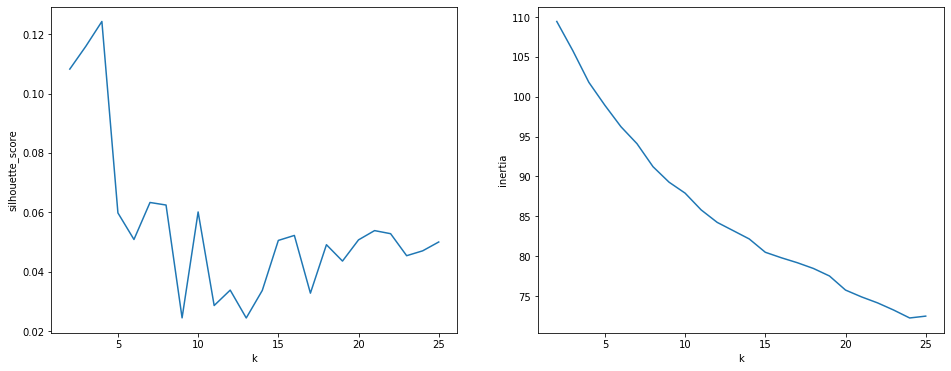

In [68]:
%matplotlib inline
grouped_clustering = grouped.drop('Neighborhood',1)
optimalKSearch(grouped_clustering,26)

The max silhouette score appears to be at 4 clusters. The inertia graph appears to change smoothly and doesn't show a very clear elbow point. Therefore the number of k clusters in this analysis will be 4 given the relatively high silhouette score

In [69]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 1, 0, 0, 0, 1, 2])

Let's insert the cluster labels into the most common venue dataset and merge it with our original data

In [70]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = pd.merge(data,neighborhoods_venues_sorted.set_index('Neighborhood'), left_on='address',right_index=True)

merged.head() # check the last columns!

City Borough Neighborhood   Latitude  Longitude  \
0  New York   Bronx    Wakefield  40.894705 -73.847201   
1  New York   Bronx   Co-op City  40.874294 -73.829939   
2  New York   Bronx  Eastchester  40.887556 -73.827806   
3  New York   Bronx    Fieldston  40.895437 -73.905643   
4  New York   Bronx    Riverdale  40.890834 -73.912585   

                        address  Cluster Labels 1st Most Common Venue  \
0    Wakefield, Bronx, New York               2              Pharmacy   
1   Co-op City, Bronx, New York               2    Athletics & Sports   
2  Eastchester, Bronx, New York               2  Caribbean Restaurant   
3    Fieldston, Bronx, New York               2           Music Venue   
4    Riverdale, Bronx, New York               3                  Park   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Dessert Shop        Sandwich Place            Donut Shop   
1           Bus Station     Food & Drink Shop        Discount Store   
2           Bus Station                 Diner          Intersection   
3                 Plaza                 River                   Zoo   
4    Athletics & Sports                  Bank           Bus Station   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           Gas Station            Laundromat  Caribbean Restaurant   
1            Restaurant          Dessert Shop      Asian Restaurant   
2         Train Station           Pizza Place         Deli / Bodega   
3               Exhibit   Dumpling Restaurant        Duty-free Shop   
4          Home Service                 Plaza            Food Truck   

         8th Most Common Venue        9th Most Common Venue  \
0           Falafel Restaurant           English Restaurant   
1                     Pharmacy                         Park   
2                   Donut Shop           Seafood Restaurant   
3  Eastern European Restaurant            Electronics Store   
4               Duty-free Shop  Eastern European Restaurant   

  10th Most Common Venue  
0    Dumpling Restaurant  
1    Fried Chicken Joint  
2   Fast Food Restaurant  
3     English Restaurant  
4      Electronics Store

Let's map the clustered points

In [71]:
mapClusteredPoints(merged,kclusters)

At first glance Tokyo and Seoul appear have similar neighborhoods,
let's get the counts of the most common venue per neighborhood for each cluster, to get an idea of what kind of neighborhoods these clusters might represent

In [72]:
top = merged.iloc[:,5:8].groupby(
    ['Cluster Labels', '1st Most Common Venue']) \
    .count().sort_values(by=['Cluster Labels','address'],ascending=False) \
    .groupby(['Cluster Labels']).head(10)
top

address
Cluster Labels 1st Most Common Venue              
3              Park                             22
               Trail                             4
               Construction & Landscaping        2
               Asian Restaurant                  1
               Bakery                            1
               Coffee Shop                       1
               Convenience Store                 1
               Donut Shop                        1
               Lake                              1
               Pool                              1
2              Bar                              77
               Food & Drink Shop                77
               Asian Restaurant                 62
               Café                             35
               Coffee Shop                      34
               Pizza Place                      24
               Athletics & Sports               22
               Bakery                           17
               Convenience Store                17
               Clothing Store                   16
1              Athletics & Sports               14
               Food & Drink Shop                 4
               Café                              2
               Construction & Landscaping        2
               Convenience Store                 2
               Bakery                            1
               Bar                               1
               Breakfast Spot                    1
               Burger Joint                      1
               Bus Stop                          1
0              Asian Restaurant                223
               Coffee Shop                      10
               Bakery                            4
               Café                              4
               Convenience Store                 4
               Bar                               3
               Food & Drink Shop                 2
               Athletics & Sports                1
               BBQ Joint                         1
               Bus Station                       1

Given the results above, the clusters could be labeled in the following way:
0. **Asian Restaurants**
1. **Athletics & Sports**
2. **Bars**
3. **Parks**

### City Clustering analysis

Now that the neighborhoods have been clustered, we can use that cluster label to find similar cities.
First let's get rates for the cluster labels per city

In [73]:
cluster_counts = merged[['City','address','Cluster Labels']].groupby(['City','Cluster Labels']).count()
cluster_rates = cluster_counts.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack().fillna(0).reset_index()
cluster_rates.columns = cluster_rates.columns.droplevel()
cluster_rates.rename(columns={cluster_rates.columns[0]:'City'},inplace=True)
cluster_rates

Cluster Labels      City          0          1          2          3
0                 Berlin   5.376344   3.225806  87.096774   4.301075
1                 London   1.680672   2.521008  93.277311   2.521008
2               New York   4.605263   3.618421  88.815789   2.960526
3                  Seoul  61.983471   3.719008  30.165289   4.132231
4                  Tokyo  75.471698   0.943396  23.584906   0.000000
5                Toronto  11.111111  14.141414  63.636364  11.111111

Let's visualise these rates with a stacked bar chart

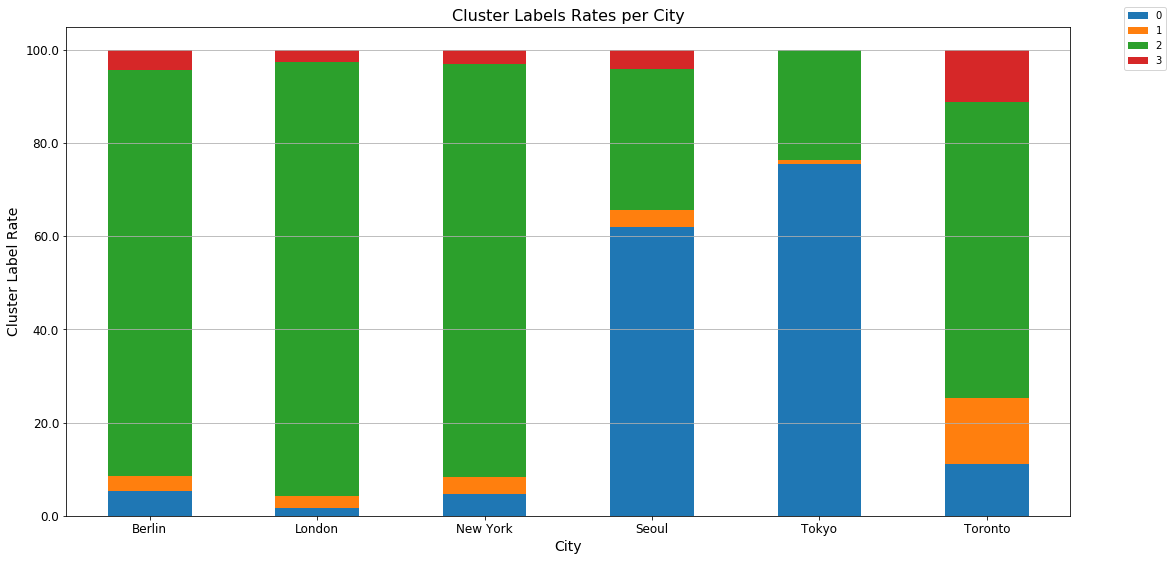

In [74]:
ax = cluster_rates.plot.bar(xticks=cluster_rates.index,figsize=(18,9),stacked=True,rot=0)
ax.grid(True,axis='y')
ax.set_xticklabels(cluster_rates['City'],size='12')
vals = ax.get_yticks()
ax.set_yticklabels(vals,size='12')
ax.set_xlabel('City',size='14')
ax.set_ylabel('Cluster Label Rate',size='14')
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Cluster Labels Rates per City',size='16')
fig = ax.get_figure()

At first glance Seoul and Tokyo stand out as being the most similar, what about the other 4 cities? Let's create a hierarchichal clustering of the cities using the cluster label rates and visualise this with a dendrogram.

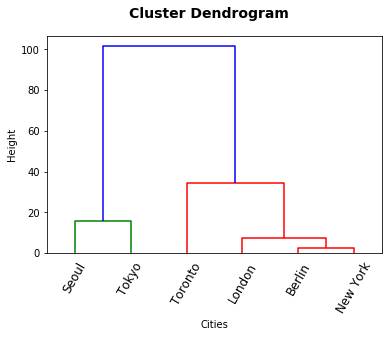

In [75]:
city_clustering = cluster_rates.drop('City',1)
distxy = squareform(squareform(pdist(city_clustering, metric='euclidean')))

# perform clustering and plot the dendrogram
R = dendrogram(linkage(distxy, method='complete'),no_plot=True)

temp = {R["leaves"][i]: cluster_rates.iloc[R["leaves"][i],0] for i in range(len(R["leaves"]))}
def llf(x):
    return "{}".format(temp[x])

dendrogram(linkage(distxy, method='complete'),
           leaf_label_func=llf,
           leaf_rotation=60.,
           leaf_font_size=12.,)

plt.xlabel('Cities')
plt.ylabel('Height')
plt.suptitle('Cluster Dendrogram', fontweight='bold', fontsize=14);

New York seems to be the similar to Berlin. This graph clearly shows a divide between far eastern capitals and western capital.
Out of the 4 western capital cities, Toronto seems to be the most different.

This concludes the analysis. Neighborhoods from six capital cities (2 in Far East Asia, 2 in Europe and 2 in North America) were clustered revealing 4 clusters. These clusters were then used to furher cluster the capital cities in order to find the similarities between these capitals. Seoul and Tokyo cluster together into a Far Eastern cluster, while western capital cluster together, with Toronto being the most dissimilar one.

## Results and Discussion <a id="results"></a>

The analysis shows that despite being in opposite sides of oceans, capital cities share neighborhoods with very similar venue profiles. 4 types of neighborhoods were identified being: Asian restaurants Neighborhoods, Athletics & Sports Neighborhoods, Bars Neighborhoods and Parks Neighborhoods.

Based on the rates of the neighborhoods in the capital cities, capital cities were clustered to reveal the similarities between the capitals.
With high rates of Asian restaurants Neighborhoods, Seoul and Tokyo are similar to each other, while the western capital with higher varieties in neighborhood types cluster together. Out of the western capitals, surprisingly Berlin and New York were the most similar, while Toronto stands out in what it could be a possibly different clusters.

To the question of which capital city travel agencies could recommend to their clients given they liked New York,
the answer would be Berlin, given our current data.This question could be expanded into a city recommendation engine for travel agencies, if we could gather data for not only other capital cities, but any city with the methods used in this study.

However great challenges lie in the data gathering steps given language barries, non-systemized datasets and different definitions for neighborhoods depending on countries. 

## Conclusion <a id="conclusion"></a>

The purpose of this analyis was to identify the most similar out of 5 capital cities to New York in order to aid travel agencies who wish to recommend travel places more efficiently to their customers who liked New York.
Neighborhood data and geospacial data were gathered from different sources such as, wikipedia, large csv files and json files.
Venues data were gathered using the foursquare API. These datasets were merged and the most common venues were identified for each neighborhood. These neighborhoods were then clustered based on their most common venues.
Given these new cluster labels, Capitals were further clustered to reveal similarities between capital cities.

Expansion of this analysis into a full recommendation engine could be built by gathering data from multiple cities and carrying out a similar analysis.